# Define the Model

In [1]:
# load librispeech dataset
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz -P ./data/train/
!tar -xf ./data/train/dev-clean.tar.gz -C ./data/train/

--2024-12-03 01:08:30--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/dev-clean.tar.gz [following]
--2024-12-03 01:08:31--  https://openslr.elda.org/resources/12/dev-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘./data/train/dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  15.8MB/s    in 23s     

2024-12-03 01:08:55 (14.1 MB/s) - ‘./data/train/dev-clean.tar.gz’ saved [337926286/337926286]



In [2]:
# load librispeech dataset
!wget https://www.openslr.org/resources/12/test-clean.tar.gz -P ./data/test/
!tar -xf ./data/test/test-clean.tar.gz -C ./data/test/

--2024-12-03 01:08:58--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/test-clean.tar.gz [following]
--2024-12-03 01:08:59--  https://openslr.elda.org/resources/12/test-clean.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘./data/test/test-clean.tar.gz’

test-clean.tar.gz   100%[===================>] 330.60M  15.3MB/s    in 23s     

2024-12-03 01:09:23 (14.1 MB/s) - ‘./data/test/test-clean.tar.gz’ saved [346663984/346663984]



# START AYUSH'S CODE

In [4]:
"""
Created on Wed Nov 27 11:55:53 2024
@author: Ayush
"""

import os
import random
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display

# Preprocessing class for handling audio files
class Preprocessing:
    def load_audio(self, file_path: str) -> np.ndarray:
        """
        Load an audio file and return its waveform as a numpy array.
        Parameters:
        file_path (str): Path to the audio file.
        Returns:
        np.ndarray: Audio waveform, and sample rate.
        """
        audio, sr = librosa.load(file_path, sr=None)  # Load audio with original sampling rate
        return audio, sr

    def extract_spectrogram(self, audio: np.ndarray, sr: int = 22050) -> np.ndarray:
        """
        Convert the audio waveform to a Mel spectrogram.
        Parameters:
        audio (np.ndarray): The audio waveform.
        sr (int): The sampling rate of the audio.
        Returns:
        np.ndarray: Spectrogram (magnitude in decibels).
        """
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        return spectrogram_db

    def save_spectrogram(self, spectrogram: np.ndarray, file_path: str):
        """
        Save the spectrogram as a .npy file.
        Parameters:
        spectrogram (np.ndarray): The spectrogram to save.
        file_path (str): Path where to save the spectrogram file.
        """
        np.save(file_path, spectrogram)

    def match_length(self, audio: np.ndarray, target_length: int) -> np.ndarray:
        """
        Match the length of the audio to a target length by trimming or padding.
        Parameters:
        audio (np.ndarray): Input audio waveform.
        target_length (int): Target length for the audio.
        Returns:
        np.ndarray: Length-matched audio waveform.
        """
        if len(audio) < target_length:
            # Pad with zeros if shorter
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            # Trim if longer
            audio = audio[:target_length]
        return audio

    def match_length_random(self, audio: np.ndarray, target_length: int) -> np.ndarray:
        """
        Match the length of the audio to a target length by choosing a random start point.
        Parameters:
        audio (np.ndarray): Input audio waveform.
        target_length (int): Target length for the audio.
        Returns:
        np.ndarray: Length-matched audio waveform.
        """
        if len(audio) < target_length:
            # Pad with zeros if shorter
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            # select a random segment from the audio
            start = random.randint(0, len(audio) - target_length)
            audio = audio[start:start + target_length]
        return audio

# Function to get all noise files from a directory
def get_noise_files(noise_dir: str) -> list:
    """
    Retrieve all noise file paths from the specified directory.
    Parameters:
    noise_dir (str): Path to the directory containing noise files.
    Returns:
    list: List of noise file paths.
    """
    noise_files = []
    for root, _, files in os.walk(noise_dir):
        for file in files:
            if file.endswith(('.wav', '.flac')):  # Process only supported audio files
                noise_files.append(os.path.join(root, file))
    return noise_files

# Function to augment audio with multiple noise samples and save clean spectrograms
def process_audio_with_multiple_noises(input_dir: str, output_dir: str, noise_dir: str, noise_factor: float = 0.02, n_noises: int = 5):
    """
    Process all clean audio files in the input directory, augment them with multiple noise samples from the MS-SNSD folder,
    and save the processed audio and spectrograms, including the clean spectrogram.
    Parameters:
    input_dir (str): Path to the directory containing clean audio files.
    output_dir (str): Path to the directory for saving augmented audio and spectrograms.
    noise_dir (str): Path to the MS-SNSD noise folder.
    noise_factor (float): The factor by which noise is added to clean audio.
    n_noises (int): Number of random noise samples to apply to each clean audio file.
    """
    preprocess = Preprocessing()
    noise_files = get_noise_files(noise_dir)

    if not noise_files:
        print("No noise files found in the specified MS-SNSD directory!")
        return

    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.flac'):  # Only process .flac files
                clean_audio_path = os.path.join(root, file)
                clean_audio, sr = preprocess.load_audio(clean_audio_path)

                # Prepare output paths
                output_audio_path = os.path.join(output_dir, os.path.relpath(root, input_dir))
                if not os.path.exists(output_audio_path):
                    os.makedirs(output_audio_path)

                # Save clean spectrogram
                # clean_spectrogram = preprocess.extract_spectrogram(clean_audio, sr)
                # preprocess.save_spectrogram(clean_spectrogram, os.path.join(output_audio_path, f'clean_spectrogram_{file.replace(".flac", ".npy")}'))

                # Create multiple noisy versions
                for i in range(n_noises):
                    noise_file = random.choice(noise_files)
                    noise_audio, _ = librosa.load(noise_file, sr=None)
                    noise_audio = preprocess.match_length(noise_audio, len(clean_audio))
                    noisy_audio = clean_audio + noise_factor * noise_audio
                    noisy_audio = np.clip(noisy_audio, -1.0, 1.0)

                    # Save noisy audio
                    noisy_audio_file_path = os.path.join(output_audio_path, f'noisy_{i+1}_' + file)
                    sf.write(noisy_audio_file_path, noisy_audio, sr, format='FLAC')

                    # Extract and save noisy spectrogram
                    # noisy_spectrogram = preprocess.extract_spectrogram(noisy_audio, sr)
                    # preprocess.save_spectrogram(noisy_spectrogram, os.path.join(output_audio_path, f'noisy_spectrogram_{i+1}_' + file.replace('.flac', '.npy')))

                print(f"Processed {n_noises} noisy variants and clean spectrogram for: {clean_audio_path}")

In [5]:
# Call the function with training data
process_audio_with_multiple_noises(
    input_dir="data/train/LibriSpeech/dev-clean",  # Directory containing clean audio
    output_dir="noisy-train",  # Directory to save augmented files
    noise_dir="noise-dir",  # Directory containing noise files
    noise_factor=0.2,  # Adjust noise factor as needed
    n_noises=1  # Number of noisy variants to generate per audio file
)

Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0017.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0010.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0023.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0015.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0006.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0011.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0019.flac
Processed 1 noisy variants and clean spectrogram for: data/train/LibriSpeech/dev-clean/6241/66616/6241-66616-0018.flac
Processed 1 noisy variants and clean spectrogram

In [6]:
# Call the function with test data
process_audio_with_multiple_noises(
    input_dir="data/test/LibriSpeech/test-clean",  # Directory containing clean audio
    output_dir="noisy-test",  # Directory to save augmented files
    noise_dir="noise-dir",  # Directory containing noise files
    noise_factor=0.2,  # Adjust noise factor as needed
    n_noises=1  # Number of noisy variants to generate per audio file
)

Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0042.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0004.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0036.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0015.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0025.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0010.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0026.flac
Processed 1 noisy variants and clean spectrogram for: data/test/LibriSpeech/test-clean/8230/279154/8230-279154-0005.flac
Processed 1 noisy variants and c

# END AYUSH'S CODE

In [7]:
def load_audio_into_array(local_data_dir: str):

  all_files = []

  # load audio files into memory
  for dir1 in sorted(os.listdir(local_data_dir)):
      for dir2 in sorted(os.listdir(local_data_dir + dir1)):
          for f in sorted(os.listdir(local_data_dir + dir1 + '/' + dir2)):
              file_path = local_data_dir + dir1 + '/' + dir2 + '/' + f
              if f.endswith('.flac'):
                  all_files.append(file_path)

  return all_files

In [9]:
clean_train_dir = './data/train/LibriSpeech/dev-clean/'
noisy_train_dir = './noisy-train/'
clean_test_dir = './data/test/LibriSpeech/test-clean/'
noisy_test_dir = './noisy-test/'

clean_train_audio_files = load_audio_into_array(clean_train_dir)
noisy_train_audio_files = load_audio_into_array(noisy_train_dir)
clean_test_audio_files = load_audio_into_array(clean_test_dir)
noisy_test_audio_files = load_audio_into_array(noisy_test_dir)

print(len(clean_train_audio_files))
print(len(noisy_train_audio_files))
print(len(clean_test_audio_files))
print(len(noisy_test_audio_files))

2703
2703
2620
2620


In [10]:
from IPython.display import Audio

display(Audio(clean_train_audio_files[0]))
display(Audio(noisy_train_audio_files[0]))
display(Audio(clean_test_audio_files[0]))
display(Audio(noisy_test_audio_files[0]))

In [124]:
def extract_windows(audio: np.ndarray, preprocessing: Preprocessing, sample_rate: int = 16000, window_duration: float = 1.02):
  """
  Extract windows of sample_rate * window_duration from the audio file. Extract
  spectrograms from them and return a list with all the spectrograms.
  Parameters:
  audio (np.ndarray): audio file to extract windows from.
  preprocessing (Preprocessing): Instance of preprocessing class.
  sample_rate (int): sampling rate of the audio file.
  window_duration (float): duration of the windows in seconds.
  """
  window_samples = int(sample_rate * window_duration)

  spectrograms = []

  for start in range(0, len(audio), window_samples):
      end = start + window_samples

      window = audio[start:end]

      if len(window) < window_samples:
        # pad with silence until the window is filled
        padding = window_samples - len(window)
        window = np.pad(window, (0, padding), mode='constant')

      spectrogram = preprocessing.extract_spectrogram(window, sample_rate)
      spectrograms.append(spectrogram)

  return spectrograms

In [125]:
def get_constant_length_spectrograms(audio_files: list[str], sample_rate: int = 16000, window_duration: float = 1.02):
  """
  Extract spectrograms of a constant length from a list of audio files. Return
  the list of spectrograms.
  Parameters:
  audio_files (list[str]): list of audio file paths for extraction.
  sample_rate (int): sampling rate of the audio file.
  window_duration (float): duration of the windows in seconds.
  """
  window_samples = int(sample_rate * window_duration)
  preprocessing = Preprocessing()

  spectrograms = []

  for file in audio_files:
    audio, sr = librosa.load(file, sr=sample_rate)
    extracted_spectrograms = extract_windows(audio, preprocessing, sample_rate, window_duration)
    spectrograms.extend(extracted_spectrograms)

  return spectrograms

In [12]:
clean_train_spectrograms = get_constant_length_spectrograms(clean_train_audio_files)

In [13]:
noisy_train_spectrograms = get_constant_length_spectrograms(noisy_train_audio_files)

In [14]:
clean_test_spectrograms = get_constant_length_spectrograms(clean_test_audio_files)

In [15]:
noisy_test_spectrograms = get_constant_length_spectrograms(noisy_test_audio_files)

In [16]:
print(len(clean_train_spectrograms))
print(len(noisy_train_spectrograms))
print(len(clean_test_spectrograms))
print(len(noisy_test_spectrograms))

20351
20351
20386
20386


In [127]:
def plot_spectrogram(spectrogram, title):
  """
  Plot the spectrogram.
  Parameters:
  spectrogram (np.ndarray): The spectrogram to plot.
  title (str): Title for the plot.
  """
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram, sr=16000, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
  plt.colorbar(format='%+2.0f dB')
  plt.title(title)
  plt.tight_layout()
  plt.show()

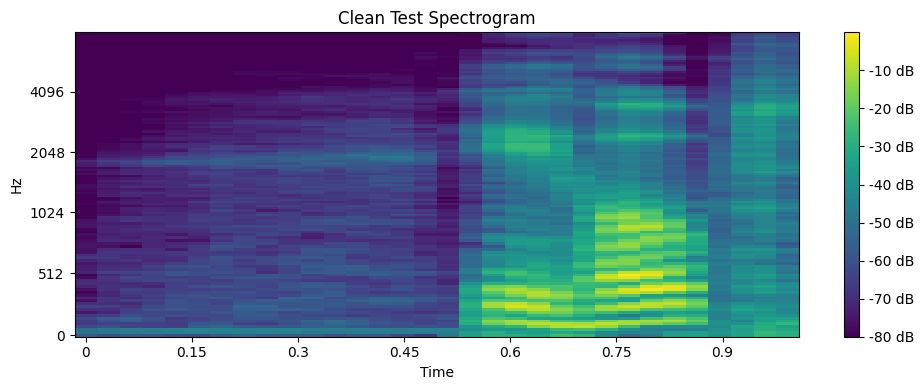

In [130]:
plot_spectrogram(clean_test_spectrograms[0], 'Clean Test Spectrogram')

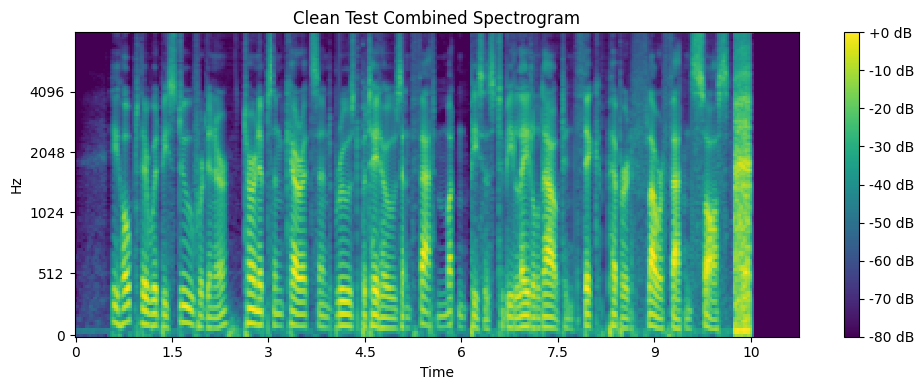

In [131]:
plot_spectrogram(np.hstack(clean_test_spectrograms[0:11]), 'Clean Test Combined Spectrogram')

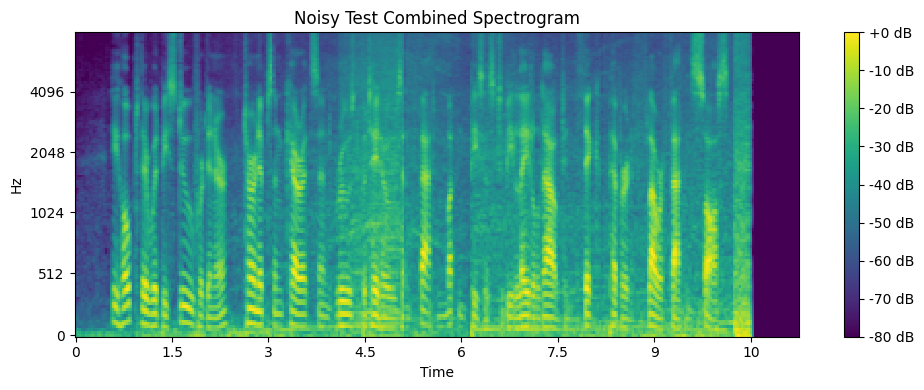

In [132]:
plot_spectrogram(np.hstack(noisy_test_spectrograms[0:11]), 'Noisy Test Combined Spectrogram')

In [133]:
def inverse_spectrogram(spectrogram: np.ndarray, volume_factor: int = 1):
  """
  Turn the spectrogram back into audio.
  Parameters:
  spectrogram (np.ndarray): The spectrogram to turn back into audio.
  volume_factor (int): The volume factor to apply to the audio.
  """
  mel_spectrogram = librosa.db_to_power(spectrogram)
  linear_spectrogram = librosa.feature.inverse.mel_to_stft(mel_spectrogram, sr=16000, n_fft=2048)
  audio_signal = librosa.griffinlim(linear_spectrogram, n_iter=32, hop_length=512, n_fft=2048)
  audio_signal *= volume_factor
  return audio_signal

In [134]:
inversed = inverse_spectrogram(np.hstack(noisy_test_spectrograms[0:11]), 10)

In [135]:
display(Audio(inversed, rate=16000))

In [74]:
def add_rgb_channels_and_normalize(spectrograms: list[np.ndarray]) -> list[np.ndarray]:
  """
  Add RGB channels to the spectrogram and normalize it.
  Parameters:
  spectrograms (list[np.ndarray]): List of spectrogram arrays.
  """
  min_val = -80
  max_val = 0

  rgb_spectrograms = np.repeat(np.array(spectrograms)[..., np.newaxis], 3, axis=-1)
  normalized_spectrograms = (rgb_spectrograms - min_val) / (max_val - min_val)

  return normalized_spectrograms

In [76]:
def add_single_channel_and_normalize(spectrograms: list[np.ndarray]) -> list[np.ndarray]:
  """
  Add single channel to the spectrogram [turn shape from (x, 128, 32) to
  (x, 128, 32, 1)] and normalize it.
  Parameters:
  spectrograms (list[np.ndarray]): List of spectrogram arrays.
  """
  min_val = -80
  max_val = 0

  rgb_spectrograms = np.repeat(np.array(spectrograms)[..., np.newaxis], 1, axis=-1)
  normalized_spectrograms = (rgb_spectrograms - min_val) / (max_val - min_val)

  return normalized_spectrograms

In [77]:
processed_clean_train_audio_files = add_single_channel_and_normalize(clean_train_spectrograms)
processed_noisy_train_audio_files = add_single_channel_and_normalize(noisy_train_spectrograms)
processed_clean_test_audio_files = add_single_channel_and_normalize(clean_test_spectrograms)
processed_noisy_test_audio_files = add_single_channel_and_normalize(noisy_test_spectrograms)

In [84]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.models import Model

def unet(input_shape=(128, 32, 1)):
  """
  Define the U-Net model for speech enhancement.
  Parameters:
  input_shape (tuple): Shape of the input spectrogram.
  """
  inputs = Input(input_shape)

  # Encoder
  c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
  c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  # Bottleneck
  b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

  # Decoder
  u1 = UpSampling2D((2, 2))(b)
  u1 = Concatenate()([u1, c2])
  c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
  c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

  u2 = UpSampling2D((2, 2))(c3)
  u2 = Concatenate()([u2, c1])
  c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
  c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

  return Model(inputs, outputs)

In [85]:
full_model = unet()
full_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 128, 32, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 128, 32, 64)    │            640 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 128, 32, 64)    │         36,928 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 16, 64)     │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 64, 16, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 64, 16, 128)    │        147,584 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 8, 128)     │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 32, 8, 256)     │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_9           │ (None, 64, 16, 256)    │              0 │ conv2d_31[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 64, 16, 384)    │              0 │ up_sampling2d_9[0][0], │
│ (Concatenate)             │                        │                │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 64, 16, 128)    │        442,496 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 64, 16, 128)    │        147,584 │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_10          │ (None, 128, 32, 128)   │              0 │ conv2d_33[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 128, 32, 192)   │              0 │ up_sampling2d_10[0][0… │
│ (Concatenate)             │                        │                │ conv2d_28[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 128, 32, 64)    │        110,656 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 128, 32, 64)    │         36,928 │ conv2d_34[0][0]        │
├──────────────────────

 Total params: 1,291,905 (4.93 MB)

 Trainable params: 1,291,905 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
import tensorflow as tf
from keras.saving import register_keras_serializable

@register_keras_serializable()
def ssim_loss(y_true, y_pred):
  """
  Compute the SSIM loss between the true and predicted spectrograms.
  Parameters:
  y_true (tf.Tensor): True spectrogram.
  y_pred (tf.Tensor): Predicted spectrogram.
  """
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [87]:
def compile_model(loc_model: keras.Model, optimizer: str, loss_function: str):
  """
  Compile the model with the given optimizer and loss function.
  Parameters:
  loc_model (keras.Model): The model to compile.
  optimizer (str): The optimizer to use.
  loss_function (str): The loss function to use.
  """
  loc_model.compile(optimizer=optimizer, loss=ssim_loss, metrics=['mae'])

In [88]:
compile_model(full_model, 'rmsprop', 'mean_squared_error')

In [42]:
def save_model(loc_model: keras.Model, file_path: str):
  """
  Save the model to the given file path.
  Parameters:
  loc_model (keras.Model): The model to save.
  file_path (str): The file path to save the model to.
  """
  loc_model.save(file_path)

In [ ]:
save_model(full_model, "updated_model.keras")

In [89]:
full_model.fit(processed_noisy_train_audio_files, processed_clean_train_audio_files, batch_size=64, epochs=50)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 79s 178ms/step - loss: 0.9351 - mae: 0.3659
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - loss: 0.9542 - mae: 0.3817
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - loss: 0.9544 - mae: 0.3814
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - loss: 0.9556 - mae: 0.3827
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - loss: 0.9546 - mae: 0.3811
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - loss: 0.9549 - mae: 0.3818
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 110ms/step - loss: 0.9559 - mae: 0.3818
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - loss: 0.9551 - mae: 0.3812
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 0.9558 - mae: 0.3820
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 0.9557 - mae: 0.3817
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 0.9548 - mae: 0.3810
Epoch 12/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 0.9548 - m

In [90]:
save_model(full_model, "trained_model_unet.keras")

In [91]:
predictions = full_model.predict(processed_noisy_test_audio_files)

638/638 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step


In [93]:
min_val = -80
max_val = 0

unscaled_predictions = predictions * (max_val - min_val) + min_val
unscaled_predictions.shape

(20386, 128, 32, 1)

In [94]:
predicted_clean_test_spectrograms = np.squeeze(unscaled_predictions, axis=-1)

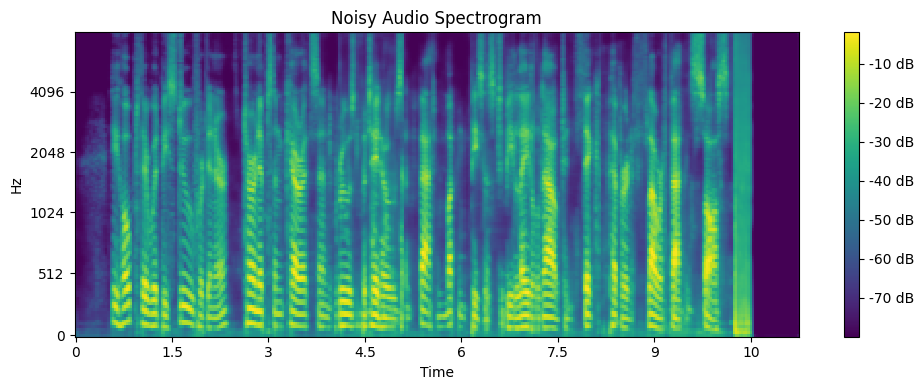

In [95]:
plot_spectrogram(np.hstack(predicted_clean_test_spectrograms[0:11]), 'Noisy Audio Spectrogram')

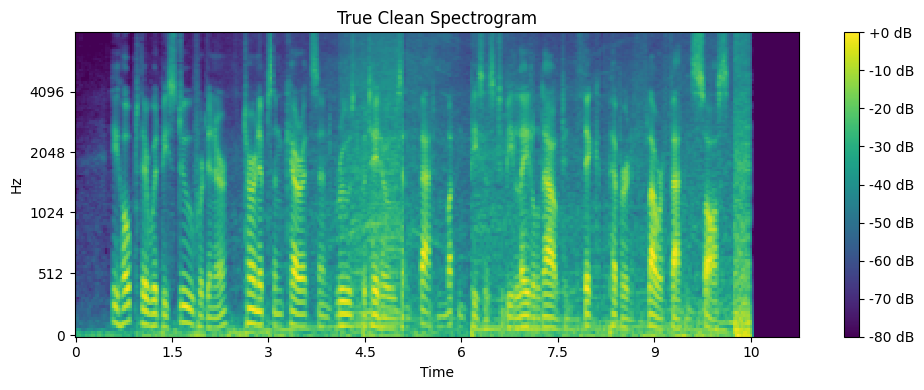

In [97]:
plot_spectrogram(np.hstack(noisy_test_spectrograms[0:11]), 'True Clean Spectrogram')

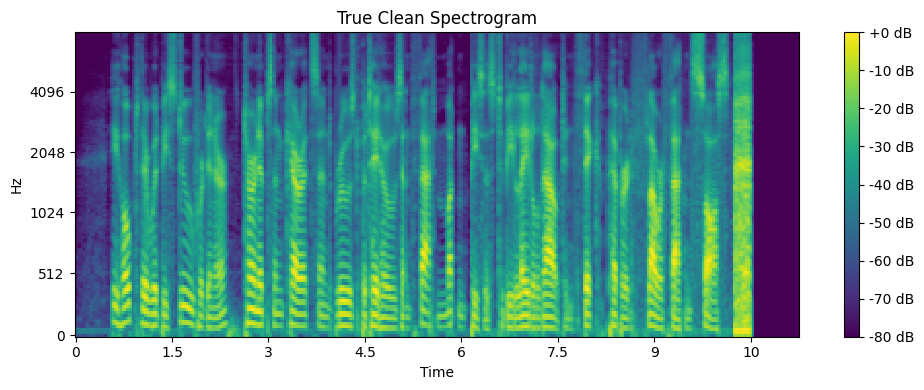

In [96]:
plot_spectrogram(np.hstack(clean_test_spectrograms[0:11]), 'True Clean Spectrogram')

In [136]:
sample_predicted_spectrogram = inverse_spectrogram(np.hstack(predicted_clean_test_spectrograms[0:11]))

In [137]:
# save audio to file
import soundfile as sf

sf.write('please_work.flac', sample_predicted_spectrogram, 16000)

In [138]:
display(Audio(sample_predicted_spectrogram, rate=16000))

In [104]:
# In order for this to work, the ssim_loss function must have the @register_keras_serializable()
# annotation along with the function in the code where the model is used
downloaded_model = keras.models.load_model('trained_model_unet.keras')

In [116]:
def denoise_audio(audio_file: str, model: keras.Model):
  """
  Denoise the audio file using the given model.
  Parameters:
  audio_file (str): The path to the audio file to denoise.
  model (keras.Model): The model to use for denoising.
  """
  audio, sr = librosa.load(audio_file, sr=16000)

  # Preprocess the audio file, turning it into spectrograms
  preprocessing = Preprocessing()
  extracted_spectrograms = extract_windows(audio, preprocessing, 16000, 1.02)
  normalized_spectrograms = add_single_channel_and_normalize(extracted_spectrograms)

  # Get predictions
  predictions = model.predict(normalized_spectrograms)

  min_val = -80
  max_val = 0

  # Process the predicted spetrograms back into audio
  unscaled_predictions = predictions * (max_val - min_val) + min_val
  predicted_spectrograms = np.squeeze(unscaled_predictions, axis=-1)
  combined_spectrogram = np.hstack(predicted_spectrograms)
  predicted_audio = inverse_spectrogram(combined_spectrogram)

  return predicted_audio

In [117]:
test_prediction = denoise_audio('./noisy-test/4446/2271/noisy_1_4446-2271-0018.flac', downloaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [118]:
# What the noisy audio sounds like
audio, sr = librosa.load('./noisy-test/4446/2271/noisy_1_4446-2271-0018.flac', sr=16000)
display(Audio(audio, rate=16000))

In [120]:
# What the predicted clean audio sounds like
display(Audio(test_prediction, rate=16000))